# AdventureWorks Försäljninganalys
I denna analys ska vi undersöka databasen AdventureWorks2025 för att besvara frågorna såsom:
- Antal produkter per kategori
- Försäljning per produktkategori
- Försäljning över tid 
- Försäljning och antal ordrar per år
- Top 10 produkter
- Försäljning och antal kunder per region 
- Genomsnittligt ordervärde per region och kundtyp 

Vi använder SQL för att hämta data och python för att visualisera analysen.




In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Jasiek2005")
server = 'localhost,1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\janek\AppData\Local\Temp\ipykernel_18864\1452838393.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str): 
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)


## Visualisering 1: Antal produkter per kategori 
Affärsfråga: Hur många produkter finns i varje kategori?

Tabbeler jag ska använda mig av: 
 Production.ProductCategory, Production.ProductSubcategory, Production.Product

 Plan: 

 - Gör en JOIN på tabellerna

 - Räkna DISTINCT produkter per kategori

 - Skapa en vertikal stapeldiagram(bar) med DESC ordning 
 
 - Analysera resultatet


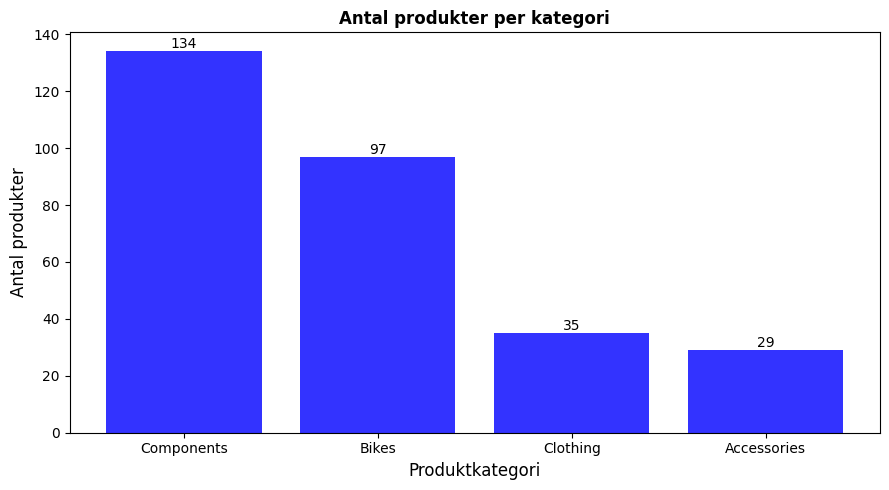

In [3]:
query_vis1 = """ 
SELECT
    pc.Name AS CategoryName, 
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc   
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name 
ORDER BY ProductCount DESC

"""

df_vis1= query_df(query_vis1)

fig,ax = plt.subplots(figsize=(9,5))
bars= ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='blue', alpha=0.8)

for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() /2,
            height,
            f'{int(height)}',
            ha ='center',
            va = 'bottom'
        )

ax.set_xlabel("Produktkategori", fontsize=12)
ax.set_ylabel("Antal produkter", fontsize=12)
ax.set_title("Antal produkter per kategori" ,fontsize=12, fontweight= 'bold')
plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori

Components är den största kategorin med 134 produkter 

Accesories är den minsta kategorin med bara 29 produkter i sin kategori

Detta indikerar att företagets största fokus ligger på komponenter som är nästan hälften av hela försäljningen och att 
Accesories och Clothing kan vara ett utvecklingsområde



## Visualisering 2: Försäljning per produktkategori
Affärsfråga: Vilka produktkategorier genererar mest intäkter?

Tabeller jag ska använda mig av: 
Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

Plan:
- Göra en join på tabellerna
- Sortera från högst till lägst försäljning
- Skapa en horisontell stapeldiagram(barh)
- Sortera staplar DESC 
- Insikter - förklara vilken kategori som är störst och minst, med exakta siffror
    


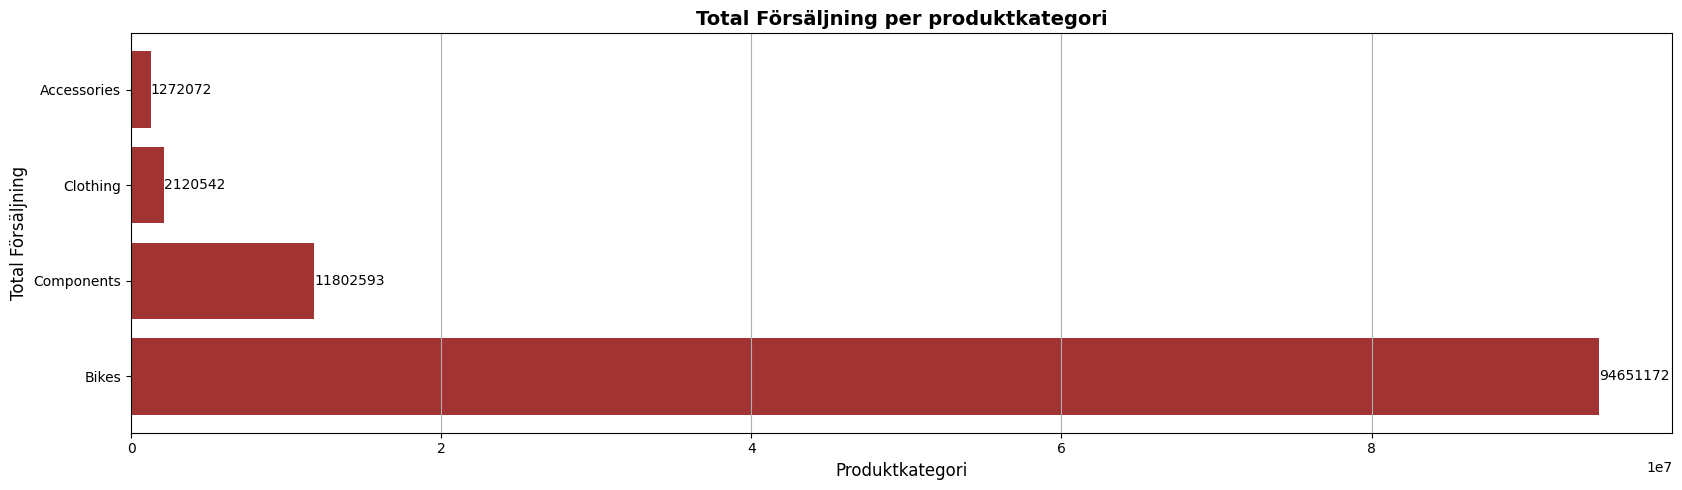

In [27]:
query_vis2 = """  
SELECT 
    pc.Name AS ProduktKategori,
    ROUND(SUM(sod.LineTotal), 2) AS TotalFörsäjning
FROM Sales.SalesOrderDetail sod 
INNER JOIN Production.Product p  ON p.ProductID = sod.ProductID 
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubCategoryID = psc.ProductSubCategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY SUM(sod.LineTotal) DESC

"""
df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(17,5))
bars = ax.barh(df_vis2['ProduktKategori'], df_vis2['TotalFörsäjning'], color = 'darkred', alpha=0.8)
for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() /2,
            f'{int(width)}',
            va ='center',
            ha = 'left'
        )
ax.set_title("Total Försäljning per produktkategori", fontweight="bold", fontsize=14)
ax.set_xlabel("Produktkategori", fontsize=12)
ax.set_ylabel("Total Försäljning", fontsize=12)
ax.grid(axis='x')
plt.tight_layout()
plt.show()



### Insikter - Försäljning per kategori
Försäljningen domineras tydligt av Bikes-kategorin med 94651172 total försäljing som står för majoriteten av intäkterna. Den minsta försäljningen har Accesories-kategorin med bara 1272072 total försäljning. 

Detta indikerar ett starkt beroende av cykelförsäljningen, samt stor obalans i intäktfördelningen. Components-kategorin har potential för tillväxt i framtiden. 

## Visualisering 3: Försäljningstrend över tid
Affärsfråga: Hur har försäljningen utvecklats över tid?

Tabeller jag ska använda mig av:
Sales.SalesOrderHeader

Plan:
- Joina tabeller
- Aggregera per månad(minst 12 månader data)
- Sortera kronologiskt(äldst först)
- Skapa en linjediagram(line plot)
- Visa tydlig tisdlinje på x-axeln
- Insikter - Beskriv trenden(ökning/minskning/säsongberoende), Nämn högsta och minsta månaden


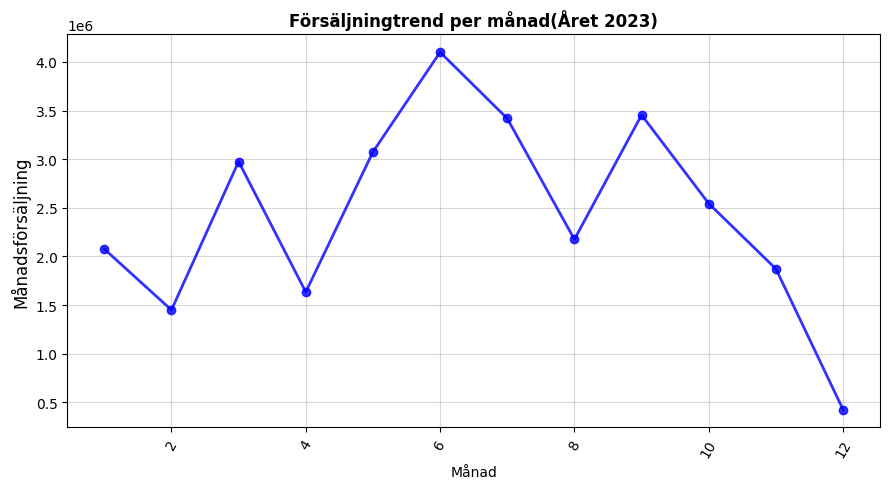

In [29]:
query_vis3 = """  
SELECT 
    MONTH(OrderDate) AS Månad,
    ROUND(SUM(SubTotal),2) AS Månadsförsäljning

FROM Sales.SalesOrderHeader 
WHERE OrderDate >= '2023-01-01' AND OrderDate < '2023-12-31'
GROUP BY MONTH(OrderDate)  
ORDER BY Månad ASC;
"""
df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(df_vis3['Månad'], df_vis3['Månadsförsäljning'], color = 'blue', alpha=0.8, marker='o', linewidth=2)
ax.set_title("Försäljningtrend per månad(Året 2023)",fontweight= 'bold', fontsize=12)
ax.set_xlabel("Månad", fontsize=10)
ax.set_ylabel("Månadsförsäljning", fontsize=12)
ax.grid(alpha=0.5)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### Insikter - Försäljningtrend över tid
Den lägsta försäljningen är i December och den högsta Juni.

Mellan April och Juni kan man se en kraftig ökning, vilket indikerar en stark efterfrågan under vårtiden. Man ser också en kraftig minskning mellan September som pågår till slutet av året som visar minskad efterfrågan under vintern.


## Visualisering 4: Försäljning och antal ordrar per år 
Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

Tabeller jag ska använda mig av:
Sales.SalesOrderHeader

Plan:
- Skapa kolumner med total försäljning och antal ordar  per år
- ORDER BY ASC
- GROUP BY Year
- Skapa en stapeldiagram(grouped bar chart)
- Insikter: Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena

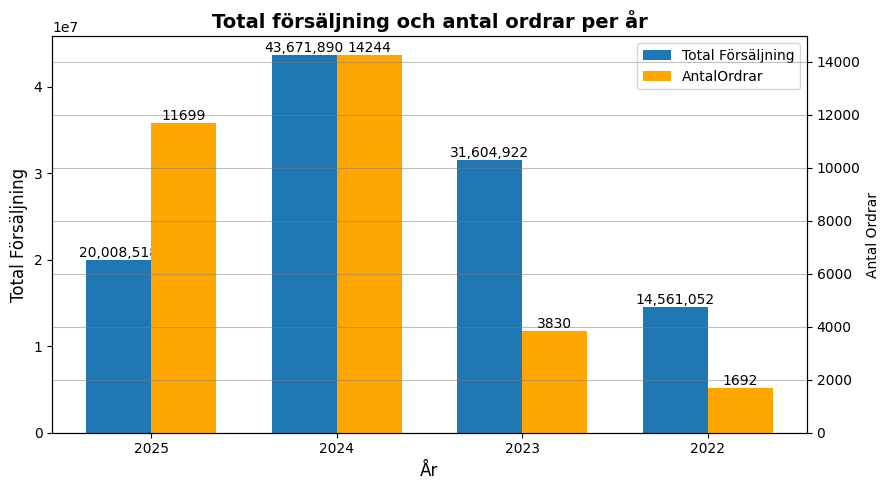

In [6]:
query_vis4 = """  
SELECT 
     YEAR(OrderDate) AS År,
     ROUND(SUM(SubTotal),2) AS TotalFörsäjning,
     COUNT(DISTINCT SalesOrderID) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY År DESC 

"""
df_vis4 = query_df(query_vis4)
x = np.arange(len(df_vis4['År']))
width=0.35
fig, ax1 = plt.subplots(figsize=(9,5))

bars1= ax1.bar(
     x - width/2,
     (df_vis4['TotalFörsäjning']),
     width,
     label= 'Total Försäljning'
)
ax1.set_ylabel('Total Försäljning',fontsize=12)

ax2 = ax1.twinx()
bars2= ax2.bar(
    x + width/2,
    df_vis4['AntalOrdrar'],
    width,
    color='orange',
    label='AntalOrdrar'
)
ax2.set_ylabel('Antal Ordrar')

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:,.0f}',
        ha='center',
        va='bottom'
    )

for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )



ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['År'])
ax1.set_xlabel('År',fontsize=12)
ax1.set_title('Total försäljning och antal ordrar per år',fontweight='bold',fontsize=14)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)
plt.grid(axis='y', color='grey', alpha=0.5)
plt.tight_layout()
plt.show()


### Insikter - Försäljning och antal ordrar per år

Året 2024 hade högst fösäljning med 43,671,890, medan 2022 hade den lägsta försäljningen under perioden med bara 14,561,052. Jamfört med tidigare år syns en tydlig ökning i den totala försäljningen samt i antalet ordrar, vilket indikerar en generell tillväxt i företaget. Detta visar också att tillväxten inte snbart drivs av högre total ordervärden utan ökad efterfrågan.

## Visualisering 5 - Top 10 produkter

Affärsfråga: Vilka 10 produkter genererar mest försäljning?

Tabeller jag ska använda mig av:
 Production.Product, Sales.SalesOrderDetail

Plan:
- Joina tabellerna
- Visa endast TOP 10 produkter
- Sortera (ORDER BY) från högst till lägst försäljning
- Skapa en horisontell stapeldiagram(barh)
- Sortera staplar från högst till lägst 
- Insikter: Nämn #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10?



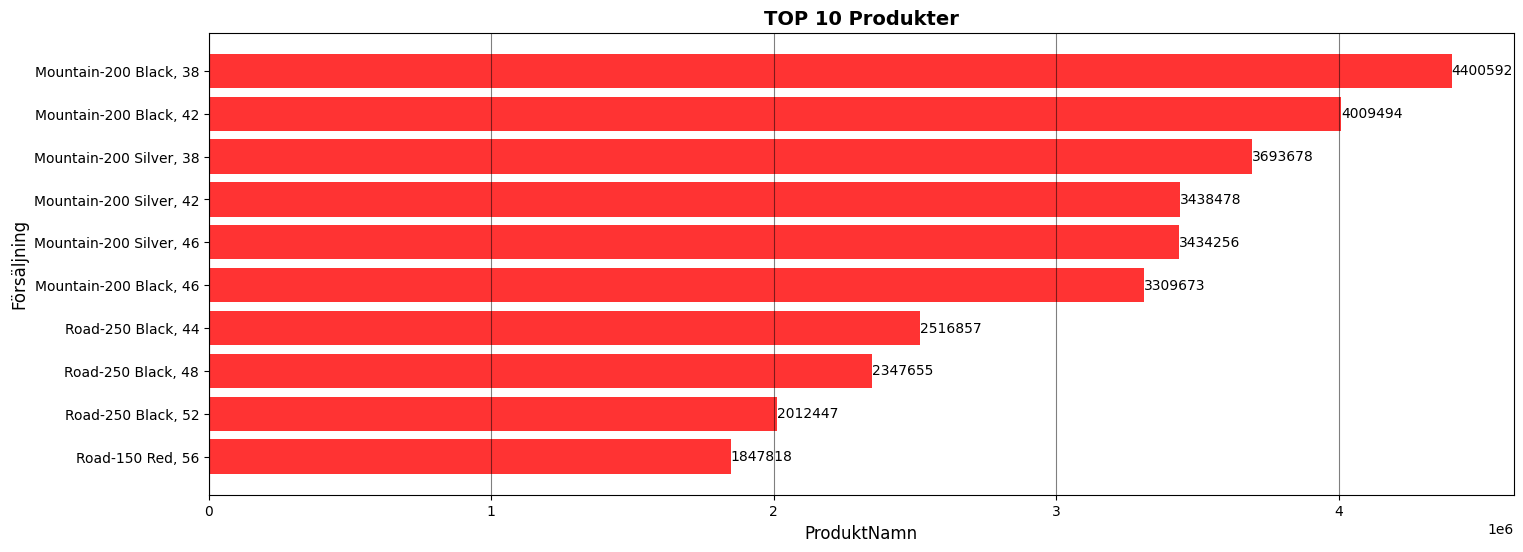

In [7]:
query_vis5 = """  
SELECT TOP 10
    p.Name AS ProduktNamn,
    SUM(sod.LineTotal) AS Försäljning
FROM Production.Product p  
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY Försäljning DESC

"""

df_vis5 = query_df(query_vis5)
df_sorted = df_vis5.sort_values(by='Försäljning', ascending=False)
fig, ax = plt.subplots(figsize=(18,6))
bars = ax.barh(
    df_sorted['ProduktNamn'],
    df_sorted['Försäljning'],
    color='red',
    alpha=0.8
)

for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() /2,
            f'{int(width)}',
            va ='center',
            ha = 'left'
        )


ax.set_title('TOP 10 Produkter', fontweight='bold', fontsize=14)
ax.set_xlabel('ProduktNamn', fontsize=12)
ax.set_ylabel('Försäljning',fontsize=12)
ax.invert_yaxis()
plt.grid(axis='x', color='black', alpha=0.5)
plt.subplots_adjust(right=0.85)
plt.show()


## Insikter - TOP 10 Produkter
Produkten med högst försäljning är Mountain-200 Black, 38 med 4400592. Bikes-kategorin dominerar starkt TOP 10 med 10 av 10 platser.


## Visualisering 6 - Försäljning och antal kunder per region

Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller jag ska använda mig av:
 Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

Plan:
- Joina tabellerna
- Visa total fösäljning och antal kunder per region.
- Sortera (ORDER BY) från högst till lägst (DESC)
- Skapa en grupperat stapeldiagram(grouped bar) med två staplar per region
- En stapel för antal kunder och en för försäljning
- Sortera regioner från högst
- Insikter: Vilken region är starkast/svagast? Jämför: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det?


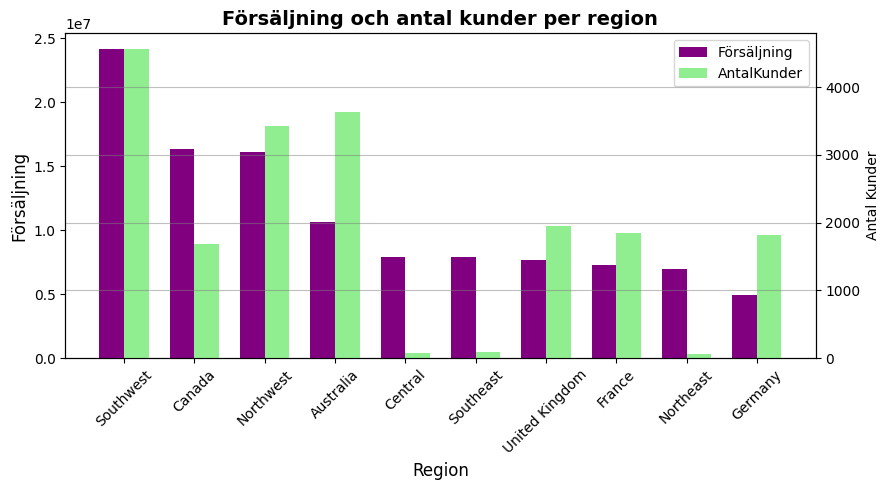

In [8]:
query_vis6 = """  
SELECT 
    st.Name AS Region,
    SUM(soh.SubTotal) AS Försäljning,
    COUNT(DISTINCT(C.CustomerID)) AS AntalKunder
FROM Sales.SalesTerritory st  
INNER JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name 
ORDER BY Försäljning DESC 

"""

df_vis6 = query_df(query_vis6)
x = np.arange(len(df_vis6['Region']))
width=0.35
fig, ax1 = plt.subplots(figsize=(9,5))

bars1= ax1.bar(
     x - width/2,
     (df_vis6['Försäljning']),
     width,
     color='purple',
     label= 'Försäljning'
)
ax1.set_ylabel('Försäljning',fontsize=12)

ax2 = ax1.twinx()
bars2= ax2.bar(
    x + width/2,
    df_vis6['AntalKunder'],
    width,
    color='lightgreen',
    label='AntalKunder'
)
ax2.set_ylabel('Antal Kunder')

ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6['Region'], rotation=45)
ax1.set_xlabel('Region',fontsize=12)
ax1.set_title('Försäljning och antal kunder per region',fontweight='bold',fontsize=14)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)
plt.grid(axis='y', color='grey', alpha=0.5)
plt.tight_layout()
plt.show()

## Insikter - Försäljning och antal kunder per region
 Southwest är den starkaste regionen med, flest kunder och högsta försäljing, medan Germany har den lägsta försäljningen. Regionen med minst antal kunder är Northeast.
 Att Southwest leder i både försäljning och antal kunder tyder på att den höga försäljiningen drivs främst av många kunder snarare än stora ordervärden per kund. Detta indikerar en stark och bred marknadsnärvaro.

## Visualisering 7 - Genomsnittligt ordervärde per region och kundtyp

Affärsfråga:  Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?
Tabeller jag ska använda mig av:
 Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer, Sales.Store

Plan:
- Joina tabellerna
- Beräkna Total försäljning / Antal ordrar per region
- Dela upp på kundtyp 
- Sortera från högst till lägst genomsnitt
- Skapa en grupperat stapeldiagram(grouped bar)
- Två staplar per region(En för store, en för individual)
- Sortera regioner från högst genomsnitt(totalt)
- Insikter: Jämför Store vs Individual - vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde?


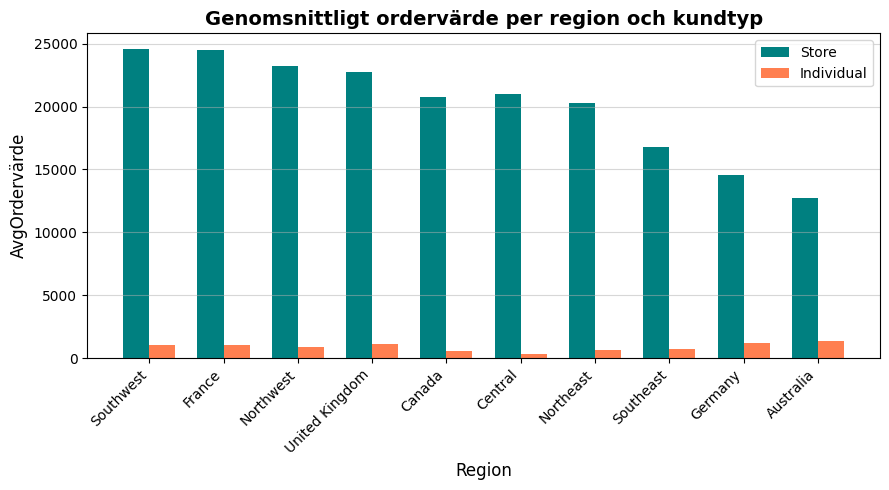

In [9]:
query_vis7 = """  
SELECT 
    st.Name AS Region,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS 'Kundtyp',
    COUNT(DISTINCT(soh.SalesOrderID)) AS AntalOrdrar,
    SUM(soh.SubTotal) AS TotalFörsäljning,
    AVG(soh.SubTotal) AS AvgOrdervärde
FROM Sales.SalesOrderHeader soh 
INNER JOIN Sales.SalesTerritory st 
ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c 
ON soh.CustomerID = c.CustomerID
GROUP BY st.Name,
        CASE 
            WHEN c.StoreID IS NOT NULL THEN 'Store'
            ELSE 'Individual'
         END


"""
df_vis7 = query_df(query_vis7)
pivot = df_vis7.pivot(
    index='Region',
    columns='Kundtyp',
    values='AvgOrdervärde'
)
pivot.columns = pivot.columns.str.strip()
pivot = pivot.reindex(columns=['Store', 'Individual'])
pivot['TotalAvg'] = pivot.mean(axis=1)
pivot = pivot.sort_values(by='TotalAvg', ascending=False)


df_sorted = df_vis7.sort_values(by='AvgOrdervärde', ascending=False)
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(
     x - width/2,
     (pivot['Store']),
     width,
     color='teal',
     label= 'Store'
)

ax.bar(
    x + width/2,
    pivot['Individual'],
    width,
    color='coral',
    label='Individual'
)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45, ha='right')
ax.set_xlabel('Region',fontsize=12)
ax.set_ylabel('AvgOrdervärde', fontsize=12)
ax.set_title('Genomsnittligt ordervärde per region och kundtyp',fontweight='bold',fontsize=14)

ax.legend()
ax.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

## Insikter - Genomsnittligt ordervärde per region och kundtyp
Store har betydligt högre genomsnittlig ordervärde än Individual i alla regioner.Genomnsnittlig ordervärde skiljer sig mellan regionerna, men mönstret är konsekvent Store > Individual. Skillnaden kan man förklara med att Store har nästan alltid hög ordervärde, då de beställer större volymer. Individual kunder handlar i mindre kvantiteter och mer sporadiskt. Store i Southwest kombinationen har högst genomsnittlig ordervärde. Store i France var också ganska nära.


## Visualisering 8 - Produktportfölj-analys 

Analysfrågor:
 
-	Vilka produkter är "winners" (hög försäljning, hög marginal)?
    
-	Vilka är "losers" (låg försäljning eller negativ marginal)?

-	Vilka produkter bör vi sluta sälja? Vilka bör vi satsa mer på?

-	Finns produkter med hög kvantitet men låg intäkt?

Tabeller jag ska använda mig av: 
    Production.Product, Sales.SalesOrderHeader, Sales.SalesOrderDetail

Plan:

- Joina tabellerna

- Beräkna Försäljning

- Beräkna Marginal           | UnitPrice - StandardCost * OrderQty

- Beräkna Marginal i procent | LineTotal - StandardCost * OrderQty / LineTotal

- Struktera om / Dela upp SQLn för Winners och Losers Visualiseringen 

- Skapa en pivottabell för att jamföra kategorier, sorterat med högst Försäljning först

- Skapa visualsiering för Försäljning vs Marginal, TOP 10(WINNERS), BOTTOM10(LOSERS) och Kvantitet vs Försäljning. 

In [10]:
query_vispiv = """ 
SELECT 
    pc.Name AS Kategori,
    COUNT(DISTINCT p.ProductID) AS AntalProdukter,
    SUM(sod.OrderQty) AS TotalKvantitet,
    SUM(sod.LineTotal) AS Försäljning,
    SUM((sod.UnitPrice - p.StandardCost) * sod.OrderQty) AS  Marginal,
     100.0 *
        SUM(sod.LineTotal - (p.StandardCost * sod.OrderQty))
        / SUM(sod.LineTotal) AS MarginalProcent
FROM Sales.SalesOrderDetail sod 
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc  ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY Försäljning DESC 

"""
df_vispiv = query_df(query_vispiv)
pd.options.display.float_format = '{:,.0f}'.format
df_vispiv = df_vispiv.rename(columns={
    'AntalProdukter': 'Antal Produkter',
    'TotalKvantitet': 'Total Kvantitet',
    'MarginalProcent': 'Marginal(%)'
})
display(df_vispiv)

,Kategori,Antal Produkter,Total Kvantitet,Försäljning,Marginal,Marginal(%)
0,Bikes,97,90268,"94,651,173","8,431,035",8
1,Components,111,49044,"11,802,593","495,448",4
2,Clothing,34,73670,"2,120,543","329,847",15
3,Accessories,24,61932,"1,272,073","643,082",50


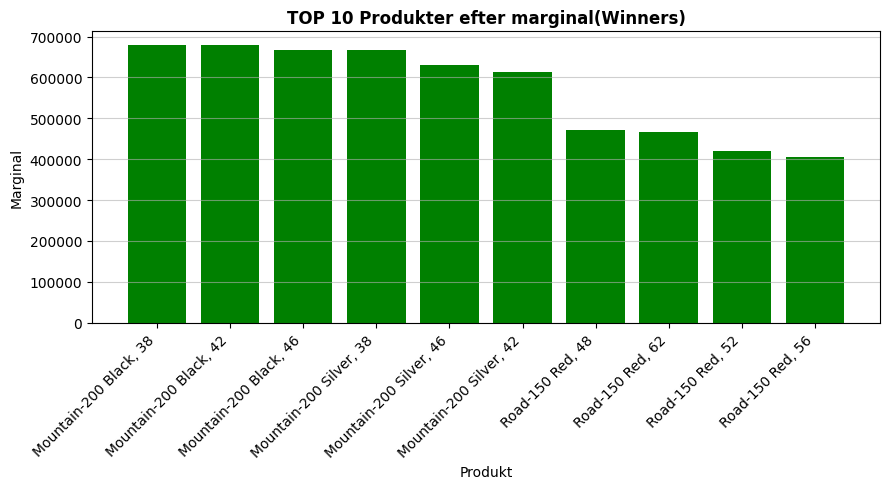

In [31]:
query_vis8win = """  
SELECT TOP 10
    p.ProductID AS ProduktID,
    p.Name as ProduktNamn,
    SUM(sod.LineTotal) AS Försäljning,
    SUM((sod.UnitPrice - p.StandardCost) * sod.OrderQty) AS  Marginal,
    100 * SUM(sod.LineTotal - (p.StandardCost * sod.OrderQty)) / SUM(sod.LineTotal) AS MarginalProcent
FROM Sales.SalesOrderDetail sod 
INNER JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY P.ProductID, p.Name
ORDER BY Marginal DESC 

"""
df_vis8win = query_df(query_vis8win)
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(df_vis8win['ProduktNamn'], df_vis8win['Marginal'], color='green')
plt.xticks(rotation=45, ha='right')
ax.set_title('TOP 10 Produkter efter marginal(Winners)',fontweight='bold',fontsize=12)
ax.set_xlabel('Produkt',fontsize=10)
ax.set_ylabel('Marginal',fontsize=10)
ax.grid(axis='y',alpha=0.6)
plt.tight_layout()
plt.show()

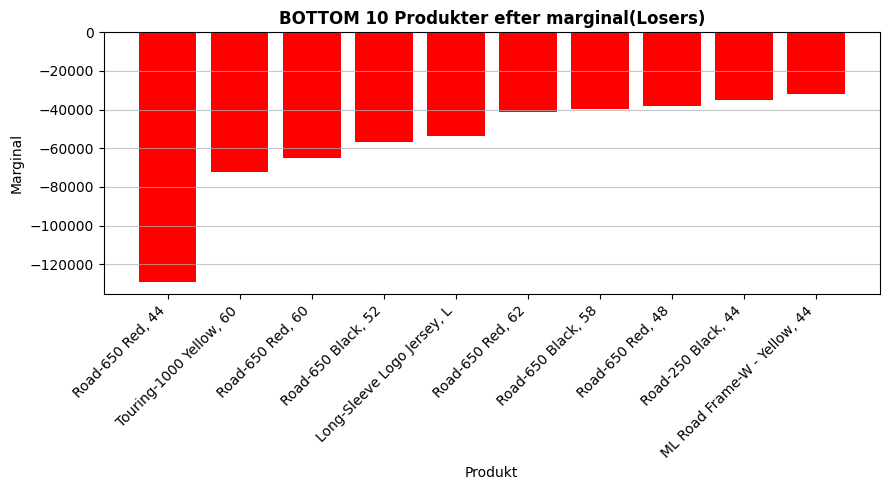

In [36]:
query_vis8lose = """  
SELECT TOP 10 
    p.ProductID AS ProduktID,
    p.Name as ProduktNamn,
    SUM(sod.LineTotal) AS Försäljning,
    SUM((sod.UnitPrice - p.StandardCost) * sod.OrderQty) AS  Marginal,
    100 * SUM(sod.LineTotal - (p.StandardCost * sod.OrderQty)) / SUM(sod.LineTotal) AS MarginalProcent
FROM Sales.SalesOrderDetail sod 
INNER JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY P.ProductID, p.Name
ORDER BY Marginal ASC

"""
df_vis8lose= query_df(query_vis8lose)
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(df_vis8lose['ProduktNamn'], df_vis8lose['Marginal'], color='red')
plt.xticks(rotation=45, ha='right')
ax.set_title('BOTTOM 10 Produkter efter marginal(Losers)',fontweight='bold',fontsize=12)
ax.set_xlabel('Produkt',fontsize=10)
ax.set_ylabel('Marginal',fontsize=10)
ax.grid(axis='y',alpha=0.7)
plt.tight_layout()
plt.show()


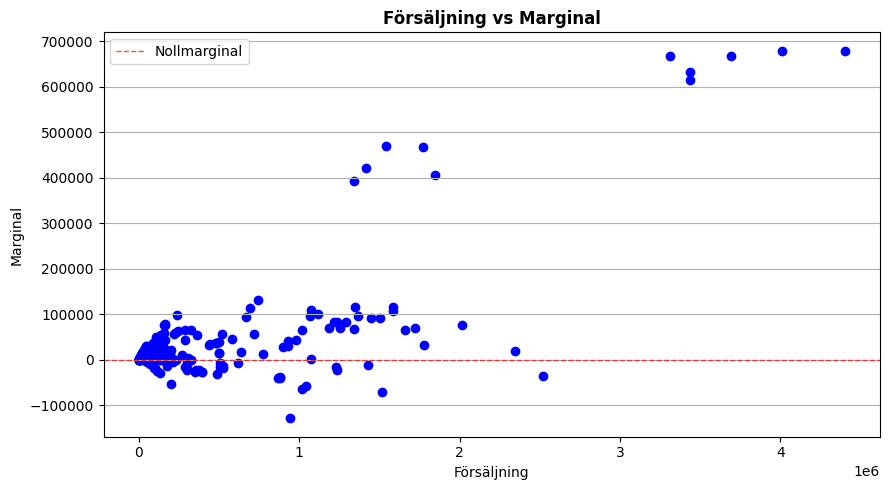

In [21]:
query_vis8 = """  
SELECT 
    p.ProductID AS ProduktID,
    p.Name as ProduktNamn,
    SUM(sod.LineTotal) AS Försäljning,
    SUM((sod.UnitPrice - p.StandardCost) * sod.OrderQty) AS  Marginal,
    100 * SUM(sod.LineTotal - (p.StandardCost * sod.OrderQty)) / SUM(sod.LineTotal) AS MarginalProcent
FROM Sales.SalesOrderDetail sod 
INNER JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY P.ProductID, p.Name
ORDER BY Marginal DESC 

"""
df_vis8 = query_df(query_vis8)
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(df_vis8['Försäljning'], df_vis8['Marginal'], color='blue')
ax.set_title('Försäljning vs Marginal',fontweight='bold',fontsize=12)
ax.set_xlabel('Försäljning',fontsize=10) 
ax.set_ylabel('Marginal', fontsize=10) 
ax.axhline(0, color='red', linewidth=1, linestyle='--', label='Nollmarginal', alpha=0.7)
ax.legend()
plt.grid(axis='y') 
plt.tight_layout() 
plt.show() 

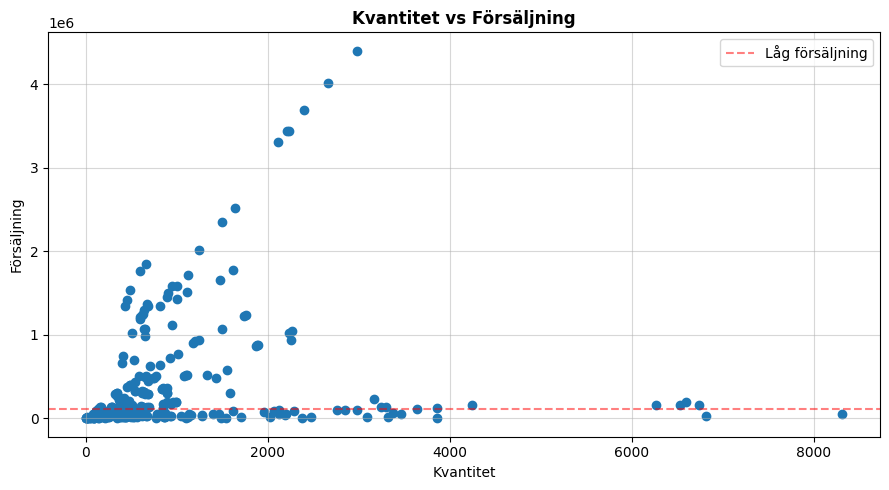

In [34]:
query_vis8highQty=""" 
SELECT 
    p.ProductID AS ProduktID,
    p.Name as ProduktNamn,
    SUM(sod.LineTotal) AS Försäljning,
    SUM(sod.OrderQty) AS Kvantitet
FROM Sales.SalesOrderDetail sod 
INNER JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY P.ProductID, p.Name
ORDER BY Kvantitet DESC, 
         Försäljning ASC 

"""
df_vis8highQty= query_df(query_vis8highQty)
fig,ax= plt.subplots(figsize=(9,5))
ax.scatter(df_vis8highQty['Kvantitet'], df_vis8highQty['Försäljning'])
ax.set_title('Kvantitet vs Försäljning', fontweight='bold', fontsize=12)
ax.set_xlabel('Kvantitet')
ax.set_ylabel('Försäljning')
ax.grid(alpha=0.5)
låg_försäljning = df_vis8highQty['Försäljning'].median()
ax.axhline(låg_försäljning, linestyle = '--', label='Låg försäljning', color='red', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


## Insikter - Visualisering 8 

Min pivottabell visar att den mest lönsamma produktkategorin när det gäller Marginal är Bikes kategorin, men när det gäller marginalprocent är Accesories den mest lönsamma kategori som indikerar att denna kategori är mest lönsam relativt sin försäljning.

Bikes - satsa på mer

Accesories - potentiell tillväxtmöjlighet

Components - prissättningproblem



- Vilka produkter är "winners" (hög försäljning, hög marginal)?
Produkter som är klassifiserade som "Winners" är (TOP 3) 

Mountain-200 Black 38,

Mountain-200 Black 42 

Mountain-200 Black 46.


- Vilka är "losers" (låg försäljning eller negativ marginal)?
Produkter som är klassificerade som "Losers" är (TOP3) 

ML Road Frame- W Yellow, 44

Road-250 Black, 44

Road-650 Red, 48


- Vilka produkter bör vi sluta sälja? Vilka bör vi satsa mer på?

Figuren 'Försäljning vs Marginal' visar relationen mellan försäljning och marginal per produkt. Produkter med hög försäljning och hög marginal identifieras som produkter att satsa mer på. Produkter med negativ marginal (som ligger under den röda linjen) indentifieras som kandidater att sluta sälja eftersom de generar förlust.

- Finns produkter med hög kvantitet men låg intäkt?

Figuren 'Kvantitet vs Försäjning' visar releationen mellan båda och indikerar att det finns flera produkter med hög fösäljningsvolym/kvantitet och låg intäkt. Detta pekar på behov av vidare analys av prisättning.


## Reflektion 

- Varför valde du denna djupanalys? Vad ville du undersöka?

Jag valde denna djupanalys, eftersom jag ville undersöka produkternas lönsamhet och prestanda samt identifiera vilka produkter som klassificeras som 'winners' eller 'losers'. Det var interessant att analysera  vilka prdukter eller produktkategorier företaget bör satsa mer på eller vilka som ska övervägas sluta sälja.

- Varför valde du att göra aggregering i SQL vs pandas?

Jag valde att göra aggregering i SQL för att dra nytta av databasens prestanda. Genom att aggregera data direkt i SQL minskar mängden data som behöver hämtas till Python och samtidigt blir det enklare, mer strukturerad och reproducerbara.

- Varför valde du dessa typer av diagram för djupanalysen?

Stapeldiagram valdes för att jamföra marginal mellan olika produkter och tydligt identifiera  'Winners' och 'Losers'. Scatter diagram valdes för att visualisera releationen mellan Försäljning och marginal, vilket ger bättre inblick kring vilka produkter som bör prioriteras eller avvecklas. Scatter för Kvantitet och Försäljning valdes för att visa relationen mellan Kvantitet och Försäljning per produkt. Scattern gör det möjligt att identifiera mönster och avvikelser som t.ex produkter med hög försäljningsvolym och låg intäkt. 

- Hur hjälpte pivot tables dig att se mönster i data?

Pivot tables gjorde det möjligt att sammanfatta, jamföra eller se skillnader mellan produkter och kategorier som var inte så uppenbara i visualsieringar. De ger bättre helehetsbild.


- Vilka utmaningar stötte du på och hur löste du dem?

En utmaning som jag stötte på under min djupanalys var att hantera stor antal produkter, vilket gjorde vissa visualiseringar svåra att tolka. Detta löstes genom filtrering och aggregering av min data. En annan utmaning var att definiera kriterier för 'winners' respektive 'losers'. Detta löstes genom att beräkna Marginal samt Marginalprocent och genom kompletterande visualiseringar.

- Vilka konkreta rekommendationer ger din djupanalys?

Mina rekommendationer är att: 
    Djupanalysen visar att företaget bör satsa mer på produkter med hög försäljning och hög marginal, särskilt inom kategorin Bikes. Accessories identifieras som en potentiell tillväxtmöjlighet tack vare hög marginalprocent, medan Components indikerar prissättningsproblem. Produkter med låg eller negativ lönsamhet bör ses över för utveckling eller avveckling, och produkter med hög kvantitet men låg försäljning bör analyseras vidare ur ett prissättningsperspektiv.

# Sammanfattning 

Analysen visar att Bikes- kategorin dominerar försäljningen och står nästan för hälften av den totala intäkten, vilket innebär starkt beroende av cykelförsäljning. Accesories och Clothing har låg försäljning men också stor potential som framtida utvecklingsområden särskilt Accesories med hög marginal. Components kategorin visar tecken på prissättningsproblem trots hög volym. Försäljning är säsongbetonad med högsta försäljingen under vår och tydlig tillväxt över tid med både försäljing och antal ordrar. Southwest är den starkaste regionen på marknaden medans Germany och Northeast är den svagaste. Store kunder har genomgående högre genomsnittligt ordervärde än Individual.

Rekommendationer: 
 - Fortsätt prioritera Bikes 
 - Satsa mer på Accesories
 - Se över Components med fokus på prissättning 
 - Anpassa lager och marknadsföring efter säsongmönster(Bäst i vår)
 - Prioritera SoutWest regionen 
 - Utveckla erbjudanden eller kampanj mot Store kunder
